### For selected ClearCut AOI prepare PlanetScope and Sentinel2 images. Show clearcuts on AOI. Compare quality

In [67]:
import os
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio.mask
import tempfile
import shapely
import re

from rasterio.features import rasterize, shapes
from shapely.geometry import Polygon, shape, box
from pathlib import Path
from datetime import datetime, timedelta

from sentinel2download.downloader import Sentinel2Downloader

In [68]:
NB_USER = os.getenv('NB_USER')

In [69]:
PATH = f"/home/{NB_USER}/work/notebooks/planet"

In [70]:
PLANET_METADATA = f"{PATH}/planet_grid.geojson"

In [122]:
planet_grid = gpd.read_file(PLANET_METADATA, driver="GeoJSON")
planet_grid.head(1)

,id,acquired,anomalous_pixels,black_fill,cloud_cover,columns,epsg_code,grid_cell,ground_control,gsd,...,clear_percent,cloud_percent,heavy_haze_percent,light_haze_percent,shadow_percent,snow_ice_percent,visible_confidence_percent,visible_percent,year,geometry
0,1336590_3761711_2018-04-08_1021,2018-04-08T07:51:44,0.01,0.34,0.006,8000,32637,3761711,1,3.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,"POLYGON ((37.68174 48.95690, 37.67582 49.18171..."


In [106]:
planet_grid.acquired[0]

'2018-04-08T07:51:44'

In [107]:
planet_grid.item_type.unique()

array(['PSOrthoTile', 'PSScene4Band', 'PSScene3Band'], dtype=object)

In [123]:
def filter_planet(grid, start_date='2019-08-01', end_date='2019-08-31'):
    # grid.acquired = pd.to_datetime(grid.acquired)
    grid = grid.loc[(grid.ground_control == "1") & 
                    (grid.item_type == "PSScene4Band") &
                    (grid.quality_category == "standard") &
                    (grid.cloud_cover == 0) &
                    (grid.acquired >= start_date) &
                    (grid.acquired <= end_date) &
                    (grid.snow_ice_percent == 0) &
                    (grid.clear_percent >= 95)].reset_index(drop=True)
    return grid

In [124]:
planet_grid = filter_planet(planet_grid)

In [128]:
def epsg_code(longitude, latitude):
    """
    Generates EPSG code from lon, lat
    :param longitude: float
    :param latitude: float
    :return: int, EPSG code
    """

    def _zone_number(lat, lon):
        if 56 <= lat < 64 and 3 <= lon < 12:
            return 32
        if 72 <= lat <= 84 and lon >= 0:
            if lon < 9:
                return 31
            elif lon < 21:
                return 33
            elif lon < 33:
                return 35
            elif lon < 42:
                return 37

        return int((lon + 180) / 6) + 1

    zone = _zone_number(latitude, longitude)

    if latitude > 0:
        return 32600 + zone
    else:
        return 32700 + zone

In [129]:
def _intersect(aoi, grid, limit=1):
    """
    Find all tiles that intersects given region with area >= limit km2
    :param limit: float, min intersection area in km2
    :return: (GeoDataFrame, epsg), precised intersected tiles and UTM zone code
    """

    
    # Get the indices of the tiles that are likely to be inside the bounding box of the given Polygon
    geometry = aoi.geometry[0]

    tiles_indexes = list(grid.sindex.intersection(geometry.bounds))
    intersected_grid = grid.loc[tiles_indexes]

    # Make the precise tiles in Polygon query
    intersected_grid = intersected_grid.loc[grid.intersects(geometry)]

    # intersection area
    epsg = epsg_code(geometry.centroid.x, geometry.centroid.y)

    # to UTM projection in meters
    aoi.to_crs(epsg=epsg, inplace=True)
    intersected_grid.to_crs(epsg=epsg, inplace=True)

    return intersected_grid, epsg

In [145]:
def _overlap_aoi_row(aoi, bbox_intersected, crs):
    
    result = list()

    intersected = bbox_intersected.copy()
    rest_aoi = gpd.GeoDataFrame([aoi], crs=crs)
    
    try:
        while rest_aoi.area.sum() > 0:
       
            res_intersection = gpd.overlay(rest_aoi, intersected, how="intersection") # intersection area with tiles
            biggest_area_id = res_intersection.area.argmax() # max intersected area

            tile_id = res_intersection.loc[biggest_area_id, "Name"]
            intersected_aoi = res_intersection.loc[biggest_area_id, "geometry"]
        
            # print(tile_id)
        
            result.append({"Name": tile_id, "geometry": intersected_aoi}) # store max intersected aoi and tile geometry
            biggest_tile = intersected.loc[intersected.Name == tile_id]

            rest_aoi = gpd.overlay(rest_aoi, biggest_tile, how="difference") # aoi minus biggest tile
            intersected = intersected[intersected.Name != tile_id] # remove used tile
    except Exception as ex:
        print(f"Error: {str(ex)}")
        
    return result

In [131]:
sentinel_grid_path = "sentinel2grid.geojson"

In [132]:
sentinel_grid = gpd.read_file(sentinel_grid_path)
sentinel_grid.head()

,Name,geometry
0,01CCV,"POLYGON Z ((180.000 -73.060 0.000, 176.865 -72..."
1,01CCV,"POLYGON Z ((-180.000 -72.073 0.000, -179.627 -..."
2,01CDH,"POLYGON Z ((180.000 -83.809 0.000, 174.713 -83..."
3,01CDH,"POLYGON Z ((-180.000 -82.826 0.000, -176.297 -..."
4,01CDJ,"POLYGON Z ((180.000 -82.913 0.000, 175.748 -82..."


In [133]:
def read_aoi(path, crs="epsg:4326"):
    df = gpd.read_file(path) 
    if str(df.crs) != crs:
        print(f"{path}: {df.crs}. Transform to {crs}")
    df.to_crs(crs, inplace=True)
    return df

In [134]:
aoi = read_aoi("AOI.geojson") 

In [135]:
def overlap(aoi, grid):
    # first, find bbox intersection
    bbox = box(*aoi.total_bounds)
    bbox = gpd.GeoDataFrame(geometry=[box(*aoi.total_bounds)], crs=aoi.crs)
    
    bbox_intersected, epsg = _intersect(bbox, grid)
    # print(bbox_intersected)
    
    # precise intersection
    projected_aoi = aoi.copy().to_crs(epsg=epsg)
    
    results = list()
    for row in projected_aoi.itertuples():
        result = _overlap_aoi_row(row, bbox_intersected, projected_aoi.crs)
        results.extend(result)
        
    return gpd.GeoDataFrame(results, crs=epsg)

In [136]:
sentinel_tiles = overlap(aoi, sentinel_grid)
sentinel_tiles 

,id,geometry
0,36UXA,"POLYGON Z ((670757.703 5556520.838 0.000, 6709..."


In [138]:
planet_grid = planet_grid[['id', 'acquired', 'geometry']].copy()
planet_grid.rename(columns={"id": "Name"}, inplace=True)

In [146]:
planet_grid

,Name,acquired,geometry
0,20190806_063544_1054,2019-08-06T06:35:44,"POLYGON ((36.42032 49.87990, 36.73462 49.92998..."
1,20190806_063545_1054,2019-08-06T06:35:45,"POLYGON ((36.39828 49.93910, 36.71387 49.98935..."
2,20190807_064359_1052,2019-08-07T06:43:59,"POLYGON ((34.97524 50.02231, 35.29419 50.06928..."
3,20190807_064400_1052,2019-08-07T06:44:00,"POLYGON ((34.97594 50.02039, 34.95445 50.08166..."
4,20190807_064401_1052,2019-08-07T06:44:01,"POLYGON ((35.27686 50.12113, 34.95649 50.07442..."
...,...,...,...
80,20190830_081516_100c,2019-08-30T08:15:16,"POLYGON ((34.65574 50.00294, 35.00808 49.94858..."
81,20190830_081707_1021,2019-08-30T08:17:07,"POLYGON ((35.62945 50.05654, 35.27845 50.11381..."
82,20190830_081708_1021,2019-08-30T08:17:08,"POLYGON ((35.60376 49.99066, 35.25423 50.04774..."
83,20190830_081709_1021,2019-08-30T08:17:09,"POLYGON ((35.57930 49.92516, 35.22936 49.98234..."


In [147]:
planet_tiles = overlap(aoi, planet_grid)

In [148]:
planet_tiles

,Name,geometry
0,20190830_063752_1020,"POLYGON ((670544.984 5552183.164, 670223.701 5..."
1,20190830_081707_1021,"POLYGON ((670757.703 5556520.838, 670989.183 5..."


In [149]:
planet_grid

,Name,acquired,geometry
0,20190806_063544_1054,2019-08-06T06:35:44,"POLYGON ((36.42032 49.87990, 36.73462 49.92998..."
1,20190806_063545_1054,2019-08-06T06:35:45,"POLYGON ((36.39828 49.93910, 36.71387 49.98935..."
2,20190807_064359_1052,2019-08-07T06:43:59,"POLYGON ((34.97524 50.02231, 35.29419 50.06928..."
3,20190807_064400_1052,2019-08-07T06:44:00,"POLYGON ((34.97594 50.02039, 34.95445 50.08166..."
4,20190807_064401_1052,2019-08-07T06:44:01,"POLYGON ((35.27686 50.12113, 34.95649 50.07442..."
...,...,...,...
80,20190830_081516_100c,2019-08-30T08:15:16,"POLYGON ((34.65574 50.00294, 35.00808 49.94858..."
81,20190830_081707_1021,2019-08-30T08:17:07,"POLYGON ((35.62945 50.05654, 35.27845 50.11381..."
82,20190830_081708_1021,2019-08-30T08:17:08,"POLYGON ((35.60376 49.99066, 35.25423 50.04774..."
83,20190830_081709_1021,2019-08-30T08:17:09,"POLYGON ((35.57930 49.92516, 35.22936 49.98234..."


In [151]:
planet_tiles = planet_tiles.merge(planet_grid[['Name', 'acquired']], on='Name')

In [152]:
planet_tiles

,Name,geometry,acquired
0,20190830_063752_1020,"POLYGON ((670544.984 5552183.164, 670223.701 5...",2019-08-30T06:37:52
1,20190830_081707_1021,"POLYGON ((670757.703 5556520.838, 670989.183 5...",2019-08-30T08:17:07


In [ ]:
def extract_tci(raster_path, temp_save_path, results_dir): 
    """
    Extracting from cropped image TCI bands to show in Results
    """
    
    with rasterio.open(raster_path) as src:
        meta = src.meta        
        meta.update({
            'count': 3, 
            'nodata': 0,
        })
        tci = src.read((1, 2, 3))        
        with rasterio.open(temp_save_path, "w", **meta) as dest:
            dest.write(tci)
            
    os.makedirs(results_dir, exist_ok=True)
    try:
        shutil.move(temp_save_path, os.path.join(results_dir, os.path.basename(temp_save_path)))
    except Exception as ex:
        print(f"Error while moving: {str(ex)}")

In [153]:
planet_path = os.path.join(PATH , '20190830_081707_1021_3B_AnalyticMS.tif')

In [154]:
def crop(input_path, output_path, polygon, name, date):
    with rasterio.open(input_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [polygon], crop=True)
        print(out_transform)
        out_meta = src.meta
        print(out_image)
        print(out_image.shape)
        
        out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform,
                 "nodata": 0,
                        })

    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.update_tags(name=name, start_date=date, end_date=date)
        dest.write(out_image)

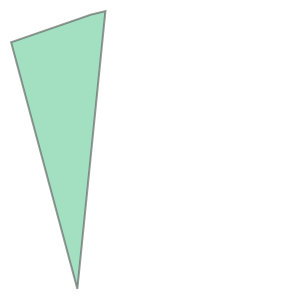

In [160]:
planet_tiles.iloc[1].geometry

In [161]:
crop(os.path.join(PATH , '20190830_063752_1020_3B_AnalyticMS.tif'), 
     os.path.join(PATH , '20190830_063752_1020_3B_AnalyticMS_cropped.tif'), planet_tiles.iloc[0].geometry, 
    "name", "2019-08-30")

| 3.00, 0.00, 664317.00|
| 0.00,-3.00, 5556087.00|
| 0.00, 0.00, 1.00|
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(4, 2361, 2076)


In [162]:
crop(os.path.join(PATH , '20190830_081707_1021_3B_AnalyticMS.tif'), 
     os.path.join(PATH , '20190830_081707_1021_3B_AnalyticMS_cropped.tif'), planet_tiles.iloc[1].geometry, 
    "name", "2019-08-30")

| 3.00, 0.00, 669495.00|
| 0.00,-3.00, 5556579.00|
| 0.00, 0.00, 1.00|
[[[   0    0    0 ...    0    0    0]
  [   0    0    0 ... 3974 3939    0]
  [   0    0    0 ... 3998 4033    0]
  ...
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ... 3412 3376    0]
  [   0    0    0 ... 3391 3407    0]
  ...
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ... 2520 2487    0]
  [   0    0    0 ... 2487 2521    0]
  ...
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]]

 [[   0    0    0 ...    0    0    0]
  [   0    0    0 ... 4329 4278    0]
  [   0    0    0 ... 4223 4181    0]
  ...
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    0    0    0]
  [   0    0    0 ...    

In [29]:
date = planet_tiles.acquired.iloc[0]

In [30]:
date

'2019-10-31T08:12:27'

In [31]:
date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S')
date = datetime(date.year, date.month, date.day)
 
delta = 2
start_date = date - timedelta(days=delta)
end_date = date + timedelta(days=delta)

In [32]:
start_date

datetime.datetime(2019, 10, 29, 0, 0)

In [33]:
end_date

datetime.datetime(2019, 11, 2, 0, 0)

In [34]:
planet_tiles.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 30°E to 36°E - by country
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
clearcuts = gpd.read_file("markup.geojson")

In [65]:
clearcuts = clearcuts.loc[(clearcuts.img_date >= '2019-08-01') & (clearcuts.img_date <= '2019-08-30')]

In [66]:
clearcuts.to_crs(planet_tiles.crs, inplace=True)

In [45]:
clearcuts

,img_date,tileID,geometry
44,2019-07-18,20190718_080402_1011,"POLYGON ((37.78731 49.90965, 37.78768 49.90945..."
56,2019-07-18,20190718_080401_1011,"POLYGON ((37.88566 49.97284, 37.88572 49.97292..."
57,2019-07-18,20190718_080400_1011,"POLYGON ((37.92223 49.98962, 37.92314 49.98906..."
58,2019-07-18,20190718_080400_1011,"POLYGON ((37.92374 49.99875, 37.92462 49.99867..."
59,2019-07-28,20190728_063110_1053,"POLYGON ((37.83647 49.94496, 37.83636 49.94429..."
60,2019-08-15,20190815_081851_45_1057,"POLYGON ((37.87459 49.97228, 37.87484 49.97228..."
63,2019-07-03,20190703_081251_0f31,"POLYGON ((36.20619 49.59016, 36.20605 49.59011..."
64,2019-08-08,20190808_080211_0e3a,"POLYGON ((36.20619 49.59016, 36.20685 49.59017..."
65,2019-08-08,20190808_080211_0e3a,"POLYGON ((36.20539 49.59016, 36.20541 49.59009..."
83,2019-06-06,20190606_081242_1024,"POLYGON ((36.05466 50.06156, 36.05522 50.06138..."


In [63]:
clearcuts.to_file(f"/home/{NB_USER}/work/notebooks/planet/clearcuts.geojson", driver='GeoJSON')

In [ ]:
BASE = f"/home/{os.getenv('NB_USER')}/work"

API_KEY = os.path.join(BASE, ".secret/sentinel2_google_api_key.json")
LOAD_DIR = os.path.join(BASE, "satellite_imagery")
RESULTS_DIR = os.path.join(BASE, "results/pbd")

PLANET_DIR = os.path.join(BASE, "notebooks/planet")

BANDS = {'TCI', }

CONSTRAINTS = {'NODATA_PIXEL_PERCENTAGE': 10.0, 'CLOUDY_PIXEL_PERCENTAGE': 5.0, }

PRODUCT_TYPE = 'L2A'

In [ ]:
def load_images(api_key, tiles, start_date, end_date, output_dir, product_type="L2A"):
    loader = Sentinel2Downloader(api_key)
    loadings = dict()
    for tile in tiles:
        print(f"Loading images for tile: {tile}...")
        loaded = loader.download(product_type,
                                 [tile],
                                 start_date=start_date,
                                 end_date=end_date,
                                 output_dir=output_dir,                       
                                 bands=BANDS,
                                constraints=CONSTRAINTS)
        
        print(f"Loading images for tile {tile} finished")
        loadings[tile] = loaded
    
    tile_folders = dict()
    for tile, tile_paths in loadings.items():
        tile_folders[tile] = {str(Path(tile_path[0]).parent) for tile_path in tile_paths}
    return tile_folders

In [ ]:
loadings = load_images(API_KEY, date_tile_info.tileID.values, START_DATE, END_DATE, LOAD_DIR, PRODUCT_TYPE)